# Object Detection

24505063 Assignment 2

### Step 1. Import the required packages


In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras import models
from keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import models, layers, regularizers
import matplotlib.pyplot as plt
import glob as glob
import cv2
from PIL import Image
%matplotlib inline



Mount the Google Drive:


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 2. Develop the YOLO v5 Model

Change directory to yolo dataset (Change this path to dataset used for YOLO v5 model)

In [3]:
%cd /content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Object_Detection/yolo

/content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Object_Detection/yolo


Clone yolov5 files

In [ ]:
!git clone https://github.com/ultralytics/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


Import the model

In [4]:
from yolov5 import utils

Change directory to cloned yolov5 files (Change this path based off of dataset used for YOLO v5 model)

In [5]:
%cd /content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Object_Detection/yolo/yolov5

/content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Object_Detection/yolo/yolov5


Install Yolov5 dependencies

In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.6/756.6 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_

Set up YAML trainig file for model architecture

In [ ]:
numClasses = 5
with open('new_train_yaml', 'w+') as file:
    file.write(
        f"""
        # parameters
        nc: {numClasses}  # number of classes
        depth_multiple: 0.33  # model depth multiple
        width_multiple: 0.50  # layer channel multiple

        # anchors
        anchors:
          - [10,13, 16,30, 33,23]  # P3/8
          - [30,61, 62,45, 59,119]  # P4/16
          - [116,90, 156,198, 373,326]  # P5/32

        # YOLOv5 backbone
        backbone:
          # [from, number, module, args]
          [[-1, 1, Focus, [64, 3]],  # 0-P1/2
           [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
           [-1, 3, BottleneckCSP, [128]],
           [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
           [-1, 9, BottleneckCSP, [256]],
           [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
           [-1, 9, BottleneckCSP, [512]],
           [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
           [-1, 1, SPP, [1024, [5, 9, 13]]],
           [-1, 3, BottleneckCSP, [1024, False]],  # 9
          ]

        # YOLOv5 head
        head:
          [[-1, 1, Conv, [512, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 6], 1, Concat, [1]],  # cat backbone P4
           [-1, 3, BottleneckCSP, [512, False]],  # 13

           [-1, 1, Conv, [256, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 4], 1, Concat, [1]],  # cat backbone P3
           [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

           [-1, 1, Conv, [256, 3, 2]],
           [[-1, 14], 1, Concat, [1]],  # cat head P4
           [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

           [-1, 1, Conv, [512, 3, 2]],
           [[-1, 10], 1, Concat, [1]],  # cat head P5
           [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

           [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
          ]
        """
    )

Set up YAML file used for dataset parsing.

In [ ]:
# Path to training dataset
train = "/content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Object_Detection/yolo/train" # Change this path as necessary
# Path to val dataset
val = "/content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Object_Detection/yolo/valid" # Change this path as necessary
# Path to test dataset
test = "/content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Object_Detection/yolo/test" # Change this path as necessary
# List the class names
classes = ['Ready', 'empty_pod', 'germination', 'pod', 'young']
#Write this data to the file
with open('new_data_yaml', 'w+') as file:
    file.write(
        f"""
        train: {train}
        val: {val}
        test: {test}

        nc: {numClasses}
        names: {classes}
        """
    )

Trian the model for 100 epochs with a batch size of 16 using yolov5m weights (Note random seeds have been set to 24505063)

In [ ]:
!python train.py --img 416 --batch 16 --epochs 100 --data new_data_yaml --cfg new_train_yaml --weights yolov5m.pt --seed 24505063

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5m.pt, cfg=new_train_yaml, data=new_data_yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_a

### 3. Evaluate the YOLOv5 model

In [6]:
!python val.py --weights runs/train/exp5/weights/best.pt --data new_data_yaml --img 416 --task train

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.6/756.6 kB 11.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [7]:
!python val.py --weights runs/train/exp5/weights/best.pt --data new_data_yaml --img 416 --task val

val: data=new_data_yaml, weights=['runs/train/exp5/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-307-g920c721e Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
new_train_yaml summary: 182 layers, 7257306 parameters, 0 gradients
val: Scanning /content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Object_Detection/yolo/valid/labels.cache... 226 images, 1 backgrounds, 0 corrupt: 100% 226/226 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instan

In [ ]:
!python val.py --weights runs/train/exp5/weights/best.pt --data new_data_yaml --img 416 --task test

val: data=new_data_yaml, weights=['runs/train/exp5/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-307-g920c721e Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
new_train_yaml summary: 182 layers, 7257306 parameters, 0 gradients
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
test: Scanning /content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Object_Detection/yolo/test/labels... 226 images, 1 backgrounds, 0 corrupt: 100% 226/226 [03:30<00:00,  1.07it/s]
test: New cache created: /content/gdri

Display testing files

In [ ]:
!ls /content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Object_Detection/yolo/yolov5/runs/val/exp5

confusion_matrix.png  PR_curve.png	     val_batch0_pred.jpg    val_batch2_labels.jpg
F1_curve.png	      R_curve.png	     val_batch1_labels.jpg  val_batch2_pred.jpg
P_curve.png	      val_batch0_labels.jpg  val_batch1_pred.jpg


Display testing outputs

In [ ]:
modelPerformanceImages = glob.glob("runs/val/exp5/*.png") + glob.glob("runs/val/exp5/*.jpg")  + glob.glob("runs/val/exp5/*.jpeg")# Specify the directory containing the model outputs

# For each image in the file
for filename in modelPerformanceImages:
    print(f"Reading file: {filename}")  # Print the file name
    plt.figure(figsize=(10, 7))  # Set the figure size
    image = plt.imread(filename)  # Read the image
    plt.imshow(image)  # Display the image
    plt.axis('off')  # Hide the axes
    plt.show()  # Show the plot



Output hidden; open in https://colab.research.google.com to view.

List available model training metadata

In [ ]:
!ls /content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Object_Detection/yolo/yolov5/runs/train/exp5

confusion_matrix.png				     PR_curve.png	    val_batch0_pred.jpg
events.out.tfevents.1715082604.0175a0f5af55.26444.0  R_curve.png	    val_batch1_labels.jpg
F1_curve.png					     results.csv	    val_batch1_pred.jpg
hyp.yaml					     results.png	    val_batch2_labels.jpg
labels_correlogram.jpg				     train_batch0.jpg	    val_batch2_pred.jpg
labels.jpg					     train_batch1.jpg	    weights
opt.yaml					     train_batch2.jpg
P_curve.png					     val_batch0_labels.jpg


Display model training charts

In [ ]:
modelPerformanceImages = glob.glob("runs/train/exp5/*.png") + glob.glob("runs/train/exp5/*.jpg") # Specify the directory containing the model outputs

# For each image in the file
for filename in modelPerformanceImages:
    print(f"Reading file: {filename}")  # Print the file name
    plt.figure(figsize=(10, 7))  # Set the figure size
    image = plt.imread(filename)  # Read the image
    plt.imshow(image)  # Display the image
    plt.axis('off')  # Hide the axes
    plt.show()  # Show the plot

Output hidden; open in https://colab.research.google.com to view.

Display some classified test image (Set path to the correct exp number and update path to dataset)

In [ ]:
!python detect.py --source '/content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Object_Detection/yolo/test/images/100010.jpg' --weights 'runs/train/exp5/weights/best.pt' --img 416 --conf 0.5 --save-txt
!python detect.py --source '/content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Object_Detection/yolo/test/images/100018.jpg' --weights 'runs/train/exp5/weights/best.pt' --img 416 --conf 0.5 --save-txt
!python detect.py --source '/content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Object_Detection/yolo/test/images/100264.jpg' --weights 'runs/train/exp5/weights/best.pt' --img 416 --conf 0.5 --save-txt

detect: weights=['runs/train/exp5/weights/best.pt'], source=/content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Object_Detection/yolo/test/images/100010.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-307-g920c721e Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
new_train_yaml summary: 182 layers, 7257306 parameters, 0 gradients
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Object_Detection/yolo/test/images/100010.jpg: 256x416 12 youngs, 49.3ms
Speed: 0.6ms pre-process, 49.3ms inference, 6

Plot images (update path as required to correct experiment)

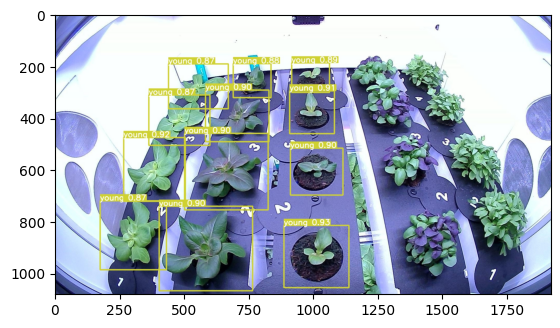

In [ ]:
image = Image.open('runs/detect/exp16/100010.jpg')
plt.imshow(image)

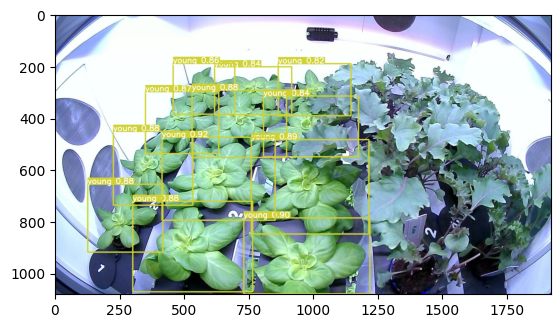

In [ ]:
image = Image.open('runs/detect/exp17/100018.jpg')
plt.imshow(image)

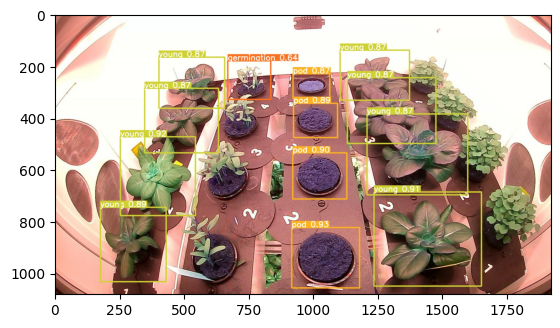

In [ ]:
image = Image.open('runs/detect/exp18/100264.jpg')
plt.imshow(image)